In [1]:
#https://www.kaggle.com/code/harshjain123/bert-for-everyone-tutorial-implementation
#https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/


import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
!pip install transformers
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.8 MB/s eta 0:00:00


In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
from pathlib import Path
print(Path.cwd())

/content


In [5]:
import pandas as pd
df = pd.read_csv('Scombined.csv')
#df.drop(['score', 'length'], inplace = True, axis = 1)
df

,selftext,y,clean,text,length,rem2
0,I've used this app called 'Relax Melodies' for...,0,I've used this app called 'Relax Melodies' for...,i ve used this app called relax melodies for o...,886,used app called relax melodies two years app i...
1,I felt reasonably tired at my bed time. I got ...,0,I felt reasonably tired at my bed time. I got ...,i felt reasonably tired at my bed time i got i...,214,felt reasonably tired bed time got bed closed ...
2,And to hear how they slept poorly the next day...,0,And to hear how they slept poorly the next day...,and to hear how they slept poorly the next day...,61,hear slept poorly next day luxury
3,"Whenever it is warm outside, there is a bird t...",0,"Whenever it is warm outside, there is a bird t...",whenever it is warm outside there is a bird th...,255,whenever warm outside bird chirps outside wind...
4,I was on 20-25mg Mirtazapine (Remeron) over th...,0,I was on 20-25mg Mirtazapine (Remeron) over th...,i was on mg mirtazapine remeron over the ...,977,mg mirtazapine remeron past years months ago b...
...,...,...,...,...,...,...
18394,"I’ve been at day 4, not many times, it’s where...",1,"I’ve been at day 4, not many times, it’s where...",i ve been at day not many times it s where i...,512,day many times incredible moodiness overwhelmi...
18395,"Hi, everyone I’m a new poster in this sub but ...",1,"Hi, everyone I’m a new poster in this sub but ...",hi everyone i m a new poster in this sub but i...,1469,hi everyone new poster sub trying see anyone e...
18396,"I have a very hard time falling asleep, I can ...",1,"I have a very hard time falling asleep, I can ...",i have a very hard time falling asleep i can b...,183,hard time falling asleep exhausted cant switch...
18397,anyone else rly want to sleep and feel tired b...,1,anyone else rly want to sleep and feel tired b...,anyone else rly want to sleep and feel tired b...,107,anyone else rly want sleep feel tired get anxi...


# New section

In [ ]:
# check class distribution
df['y'].value_counts(normalize = True)

0    0.529974
1    0.470026
Name: y, dtype: float64

In [6]:
from sklearn.model_selection import train_test_split

print(df['selftext'][5])
print()
print(df['clean'][5])

df_bert = df[['selftext', 'clean', 'y']]
df_bert.reset_index(inplace=True)

train_text, temp_text, train_labels, temp_labels = train_test_split(df_bert['selftext'], df_bert['y'],
                                                                    random_state=20,
                                                                    test_size=0.4,
                                                                    stratify=df_bert['y'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=20,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

Dealing with insomnia while packing and moving to a new place is quite the rigorous test. Hypno-sleep 'til Brooklyn? http://touch.metro.us/news/the-insomniac-files-is-the-hypnotic-trance-my-last-chance/zsJqbB---5KiVhLU99Evgk/

Dealing with insomnia while packing and moving to a new place is quite the rigorous test. Hypno-sleep 'til Brooklyn?


In [7]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 128,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 128,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 128,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [9]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [10]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [ ]:
train_seq

tensor([[ 101, 2750, 2108,  ..., 1010, 1996,  102],
        [ 101, 1020, 2420,  ...,    0,    0,    0],
        [ 101, 2061, 1010,  ..., 1006, 4983,  102],
        ...,
        [ 101, 1045, 4265,  ...,    0,    0,    0],
        [ 101, 1045, 1521,  ...,    0,    0,    0],
        [ 101, 1045, 4033,  ..., 2705, 2051,  102]])

In [ ]:
'''# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False'''

In [11]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.1)  #0.1

        # relu activation function
       # self.relu =  nn.ReLU()

        # dense layer 1
      #  self.fc1 = nn.Linear(768,512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(768,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      #  x = self.fc1(cls_hs)

#        x = self.relu(x)

        x = self.dropout(cls_hs)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

In [12]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [13]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 2e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [14]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_labels), y= train_labels)

#class_weights = dict(zip(np.unique(train_labels), class_weights))

print("Class Weights:",class_weights)

#Class Weights: [0.94350427 1.06369243]. random state 20'''

Class Weights: [0.94350427 1.06369243]


In [15]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 3      #10

In [16]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred, labels):
    #labels = pred.input_ids
    #preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, pred)
    acc = accuracy_score(labels, pred)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [17]:
#FINE TUNE

# function to train the model
def train():

    model.train()
    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)
     #   metrics = compute_metrics(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [18]:
# get predictions for val data
with torch.no_grad():
    valpreds = model(val_seq.to(device), val_mask.to(device))
    valpreds = valpreds.detach().cpu().numpy()

OutOfMemoryError: ignored

In [ ]:
import datetime
import time
#https://python-utils.readthedocs.io/en/latest/_modules/python_utils/time.html

def format_time(timestamp, precision=datetime.timedelta(seconds=1)):
    '''Formats timedelta/datetime/seconds

    >>> format_time('1')
    '0:00:01'
    >>> format_time(1.234)
    '0:00:01'
    >>> format_time(1)
    '0:00:01'
    >>> format_time(datetime.datetime(2000, 1, 2, 3, 4, 5, 6))
    '2000-01-02 03:04:05'
    >>> format_time(datetime.date(2000, 1, 2))
    '2000-01-02'
    >>> format_time(datetime.timedelta(seconds=3661))
    '1:01:01'
    >>> format_time(None)
    '--:--:--'
    >>> format_time(format_time)  # doctest: +ELLIPSIS
    Traceback (most recent call last):
        ...
    TypeError: Unknown type ...

    '''
    precision_seconds = precision.total_seconds()

    if isinstance(timestamp, six.string_types + six.integer_types + (float, )):
        try:
            castfunc = six.integer_types[-1]
            timestamp = datetime.timedelta(seconds=castfunc(timestamp))
        except OverflowError:  # pragma: no cover
            timestamp = None

    if isinstance(timestamp, datetime.timedelta):
        seconds = timestamp.total_seconds()
        # Truncate the number to the given precision
        seconds = seconds - (seconds % precision_seconds)

        return str(datetime.timedelta(seconds=seconds))
    elif isinstance(timestamp, datetime.datetime):  # pragma: no cover
        # Python 2 doesn't have the timestamp method
        if hasattr(timestamp, 'timestamp'):
            seconds = timestamp.timestamp()
        else:
            seconds = timedelta_to_seconds(timestamp - epoch)

        # Truncate the number to the given precision
        seconds = seconds - (seconds % precision_seconds)

        try:  # pragma: no cover
            if six.PY3:
                dt = datetime.datetime.fromtimestamp(seconds)
            else:
                dt = datetime.datetime.utcfromtimestamp(seconds)
        except ValueError:  # pragma: no cover
            dt = datetime.datetime.max
        return str(dt)
    elif isinstance(timestamp, datetime.date):
        return str(timestamp)
    elif timestamp is None:
        return '--:--:--'
    else:
        raise TypeError('Unknown type %s: %r' % (type(timestamp), timestamp))

In [ ]:
# function for evaluating the model
def evaluate():

    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

            # Calculate elapsed time in minutes.
           # elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        b_labels = batch[2].to(device)

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

            label_ids = b_labels.to('cpu').numpy()

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds, label_ids

In [ ]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]
train_pred = []
val_pred = []
label_ids = []

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, train_pred = train()

    #evaluate model
    valid_loss, val_pred, label_ids  = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 3
  Batch    50  of    345.
  Batch   100  of    345.
  Batch   150  of    345.
  Batch   200  of    345.
  Batch   250  of    345.
  Batch   300  of    345.

Evaluating...
  Batch    50  of    115.
  Batch   100  of    115.

Training Loss: 0.052
Validation Loss: 3.057

 Epoch 2 / 3
  Batch    50  of    345.
  Batch   100  of    345.
  Batch   150  of    345.
  Batch   200  of    345.
  Batch   250  of    345.
  Batch   300  of    345.

Evaluating...
  Batch    50  of    115.
  Batch   100  of    115.

Training Loss: 0.049
Validation Loss: 2.255

 Epoch 3 / 3
  Batch    50  of    345.
  Batch   100  of    345.
  Batch   150  of    345.
  Batch   200  of    345.
  Batch   250  of    345.
  Batch   300  of    345.

Evaluating...
  Batch    50  of    115.
  Batch   100  of    115.

Training Loss: 0.036
Validation Loss: 2.982


In [ ]:
evaluate()


Evaluating...
  Batch    50  of    115.
  Batch   100  of    115.


(3.007325177607329,
 array([[-5.3137969e-03, -5.2400999e+00],
        [-6.5388752e-04, -7.3329000e+00],
        [-5.7167263e+00, -3.2959445e-03],
        ...,
        [-9.2642294e-04, -6.9846120e+00],
        [-7.3787829e-05, -9.5142756e+00],
        [-9.3932511e-05, -9.2731152e+00]], dtype=float32),
 tensor([0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
         0, 1, 1, 0, 0, 1, 1, 1], device='cuda:0'))

In [ ]:
val_pred

array([[-5.3137969e-03, -5.2400999e+00],
       [-6.5388752e-04, -7.3329000e+00],
       [-5.7167263e+00, -3.2959445e-03],
       ...,
       [-9.2642294e-04, -6.9846120e+00],
       [-7.3787829e-05, -9.5142756e+00],
       [-9.3932511e-05, -9.2731152e+00]], dtype=float32)

In [ ]:
len(labels)

32

In [ ]:
labelsl = [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 1, 1, 0, 0, 1, 1, 1]

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
#MAKE PREDICTIONS

# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

OutOfMemoryError: ignored

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

'''       precision    recall  f1-score   support

           0       0.61      0.65      0.63      1951
           1       0.57      0.53      0.55      1729

    accuracy                           0.59      3680
   macro avg       0.59      0.59      0.59      3680
weighted avg       0.59      0.59      0.59      3680

weights

 precision    recall  f1-score   support

           0       0.60      0.65      0.63      1951
           1       0.57      0.52      0.54      1729

    accuracy                           0.59      3680
   macro avg       0.59      0.59      0.59      3680
weighted avg       0.59      0.59      0.59      3680

'''

              precision    recall  f1-score   support

           0       0.60      0.65      0.63      1951
           1       0.57      0.52      0.54      1729

    accuracy                           0.59      3680
   macro avg       0.59      0.59      0.59      3680
weighted avg       0.59      0.59      0.59      3680



'       precision    recall  f1-score   support\n\n           0       0.61      0.65      0.63      1951\n           1       0.57      0.53      0.55      1729\n\n    accuracy                           0.59      3680\n   macro avg       0.59      0.59      0.59      3680\nweighted avg       0.59      0.59      0.59      3680'

 Accuracy: 0.5894021739130435
Precision: 0.5689873417721519
 Recall: 0.5199537304800462
 F1: 0.5433665760048353


<Figure size 800x800 with 0 Axes>

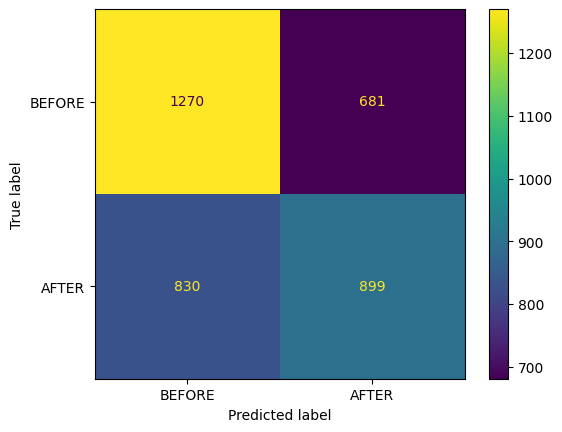

' \nwith class weights\n\nAccuracy: 0.5894021739130435\nPrecision: 0.5689873417721519\n Recall: 0.5199537304800462\n F1: 0.5433665760048353\n\n\n without\nAccuracy: 0.5918478260869565\nPrecision: 0.570804741110418\n Recall: 0.5292076344707923\n F1: 0.5492196878751501\n\n '

In [ ]:
predicted = preds
y_test = test_y
from sklearn import metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))

print(" Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Precision:",metrics.precision_score(y_test, predicted))
print(" Recall:",metrics.recall_score(y_test, predicted))
print(" F1:",metrics.f1_score(y_test, predicted))


confusion_matrix = metrics.confusion_matrix(y_test, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['BEFORE', 'AFTER'])
cm_display.plot()
plt.show()

'''
with class weights

Accuracy: 0.5894021739130435
Precision: 0.5689873417721519
 Recall: 0.5199537304800462
 F1: 0.5433665760048353


 without
Accuracy: 0.5918478260869565
Precision: 0.570804741110418
 Recall: 0.5292076344707923
 F1: 0.5492196878751501

 '''

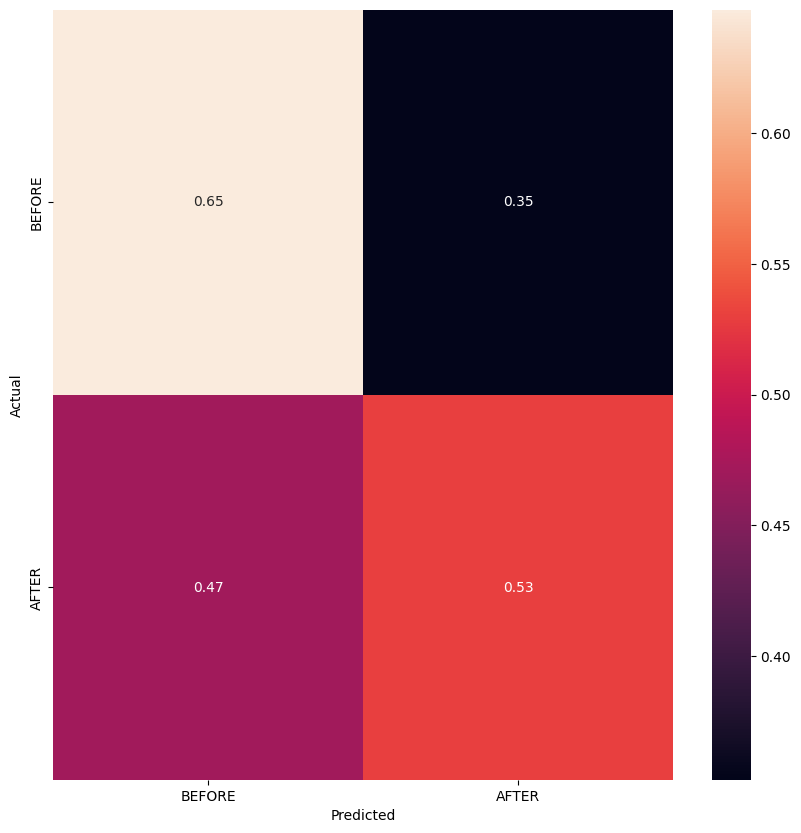

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, predicted)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['BEFORE', "AFTER"], yticklabels=['BEFORE', 'AFTER'])

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [ ]:
model

BERT_Arch(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=